In [1]:
using Gen
using Plots
include("./distribution_utils.jl")

has_argument_grads (generic function with 1 method)

In [2]:
struct FireflyState
    x::Float64
    y::Float64
    vx::Float64
    vy::Float64
    blinking::Int64
    blink_rate::Float64
end

In [131]:
@gen (static) function init_single_state()
    x = {:x} ~ uniform(1, 64)
    y = {:y} ~ uniform(1, 64)
    vx = {:vx} ~ normal(0, 1)
    vy = {:vy} ~ normal(0, 1)
    blinking = {:blinking} ~ bernoulli(0.5)
    blink_rate = {:blink_rate} ~ uniform(0.05, 0.15)
    return FireflyState(x, y, vx, vy, blinking, blink_rate)
end

@gen (static) function reverse_velocity(v::Float64)
    return normal(-v, 0.1)
end

@gen (static) function maintain_velocity(v::Float64)
    return normal(v, 0.05)
end

update_velocity = Switch(maintain_velocity, reverse_velocity)

@gen (static) function update_single_state(t::Int64, prev_state::FireflyState, scene_dim::Int64)
    prev_x = prev_state.x
    prev_y = prev_state.y
    prev_vx = prev_state.vx
    prev_vy = prev_state.vy
    switch_x = (prev_x + prev_vx < scene_dim - 1 && prev_x + prev_vx > 2) ? 1 : 2
    switch_y = (prev_y + prev_vy < scene_dim - 1 && prev_y + prev_vy > 2) ? 1 : 2

    vx ~ update_velocity(switch_x, prev_vx)
    vy ~ update_velocity(switch_y, prev_vy)
    x ~ trunc_norm(prev_x + vx, .1, 1., Float64(scene_dim))
    y ~ trunc_norm(prev_y + vy, .1, 1., Float64(scene_dim))

    blinking ~ bernoulli(prev_state.blink_rate)
    return FireflyState(x, y, vx, vy, blinking, prev_state.blink_rate)
end

init_all_states = Map(init_single_state)
chain_states_single = Unfold(update_single_state)
chain_states = Map(chain_states_single)

Gen.@load_generated_functions

In [132]:
@gen (static) function unfold_model(T::Int, scene_size::Int)
    num ~ uniform_discrete(1, 4)
    init_states = init_all_states(ones(num))
    states ~ chain_states(fill(T, num), init_states, fill(scene_size, num))
    return num, states
end

Gen.@load_generated_functions

In [133]:
# Animate a plot of the firefly states
function animate_firefly_states(trace; fps::Int64 = 10)
    steps, scene_size = get_args(trace)
    num, _ = get_retval(trace)
    choices = get_choices(trace)
    num = choices[:num]
    
    fig = plot(figsize=(500, 500))
    anim = Plots.@animate for t=1:steps
        empty!(fig)
        xlims!(0, scene_size)
        ylims!(0, scene_size)

        for i=1:num
            blinking = choices[:states => i => t => :blinking]
            x = choices[:states => i => t => :x]
            y = choices[:states => i => t => :y]
            markershape = blinking ? :circle : :x
            color = blinking ? :yellow : :black
            scatter!([x], [y], markershape=markershape, markersize=10, color=color, legend=false, background_color=:black)
        end
    end

    gif(anim, "firefly.gif", fps=fps)
end

animate_firefly_states (generic function with 1 method)

3


[ Info: Saved animation to /Users/yonifriedman/Research/ProbComp/Fireflies/firefly.gif


Plots.AnimatedGif("/Users/yonifriedman/Research/ProbComp/Fireflies/firefly.gif")
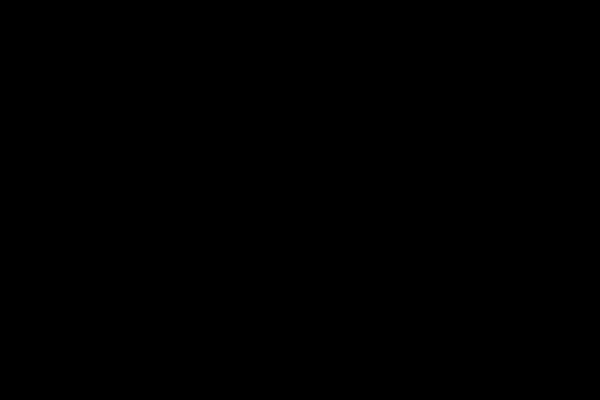

In [140]:
trace = simulate(unfold_model, (100, 64,))
println(get_choices(trace)[:num])

animate_firefly_states(trace, fps=10)
